In [1]:
# Mount Google Drive (replace with your authentication code if needed)
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Set the path to your dataset in Google Drive (replace with your actual path)
data_dir = '/content/drive/MyDrive/Plant Disease Recognition'  # Update with your actual path


In [3]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
# Define image dimensions
img_width, img_height = 224, 224

# Data augmentation for training data
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# Load training data (check for directory before loading)
print("Checking for training data directory:", data_dir + '/Train')
train_generator = train_datagen.flow_from_directory(
    data_dir + '/Train',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)


Checking for training data directory: /content/drive/MyDrive/Plant Disease Recognition/Train


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Plant Disease Recognition/Train'

In [ ]:
# Data augmentation (less aggressive) for validation data
validation_datagen = ImageDataGenerator(rescale=1./255)

# Load validation data
validation_generator = validation_datagen.flow_from_directory(
    data_dir + '/Validation',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)


Found 60 images belonging to 3 classes.


In [ ]:
# Define the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes (healthy, powdery mildew, rust)
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)


9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/20
42/42 [==============================] - 851s 20s/step - loss: 0.3886 - accuracy: 0.8410 - val_loss: 0.1111 - val_accuracy: 0.9500
Epoch 2/20
42/42 [==============================] - 101s 2s/step - loss: 0.1556 - accuracy: 0.9422 - val_loss: 0.0849 - val_accuracy: 0.9667
Epoch 3/20
42/42 [==============================] - 100s 2s/step - loss: 0.0998 - accuracy: 0.9692 - val_loss: 0.0821 - val_accuracy: 0.9833
Epoch 4/20
42/42 [==============================] - 110s 3s/step - loss: 0.0954 - accuracy: 0.9707 - val_loss: 0.0588 - val_accuracy: 0.9833
Epoch 5/20
42/42 [==============================] - 103s 2s/step - loss: 0.0700 - accuracy: 0.9760 - val_loss: 0.0847 - val_accuracy: 0.9833
Epoch 6/20
42/42 [==============================] - 104s 2s/step - loss: 0.0848 - accuracy: 0.9760 - val_loss: 0.0960 - val_accuracy: 0.9500
Epoch 7/20
42/42 [==============================] - 99s 2s/step - loss: 0.0643 - accuracy: 0.9760 - val_loss: 0.0892 - val_accuracy: 0.9667


In [ ]:
# Evaluate the model on training data
train_loss, train_accuracy = model.evaluate(train_generator)
print(f'Training Loss: {train_loss:.4f}')
print(f'Training Accuracy: {train_accuracy:.4f}')


42/42 [==============================] - 96s 2s/step - loss: 0.0492 - accuracy: 0.9835
Training Loss: 0.0492
Training Accuracy: 0.9835


In [ ]:
# Evaluate the model on validation data
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {validation_loss:.4f}')
print(f'Validation Accuracy: {validation_accuracy:.4f}')


2/2 [==============================] - 5s 2s/step - loss: 0.0892 - accuracy: 0.9667
Validation Loss: 0.0892
Validation Accuracy: 0.9667


In [ ]:
# Function to preprocess the input image
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_input_image(img_path):
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

# Function to make a prediction
def predict_disease(model, img_array):
    predictions = model.predict(img_array)
    class_indices = train_generator.class_indices
    class_names = list(class_indices.keys())
    predicted_class = class_names[np.argmax(predictions)]
    return predicted_class


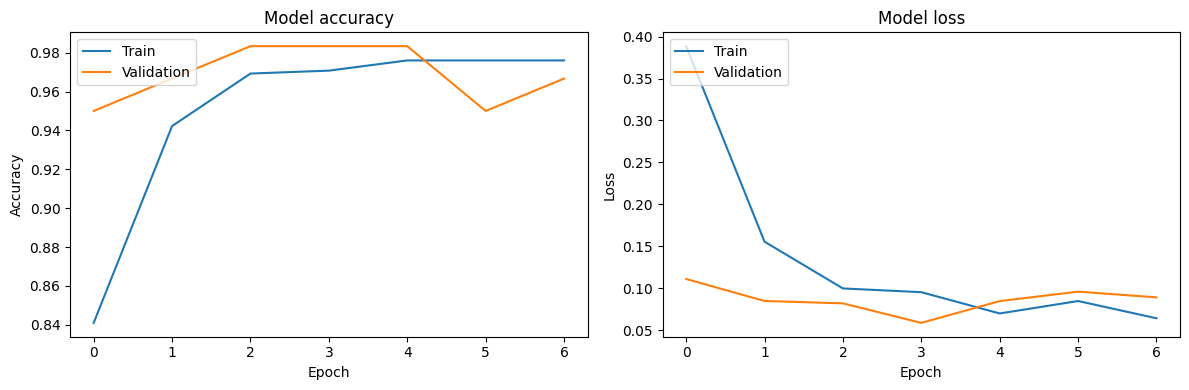

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


2/2 [==============================] - 6s 2s/step


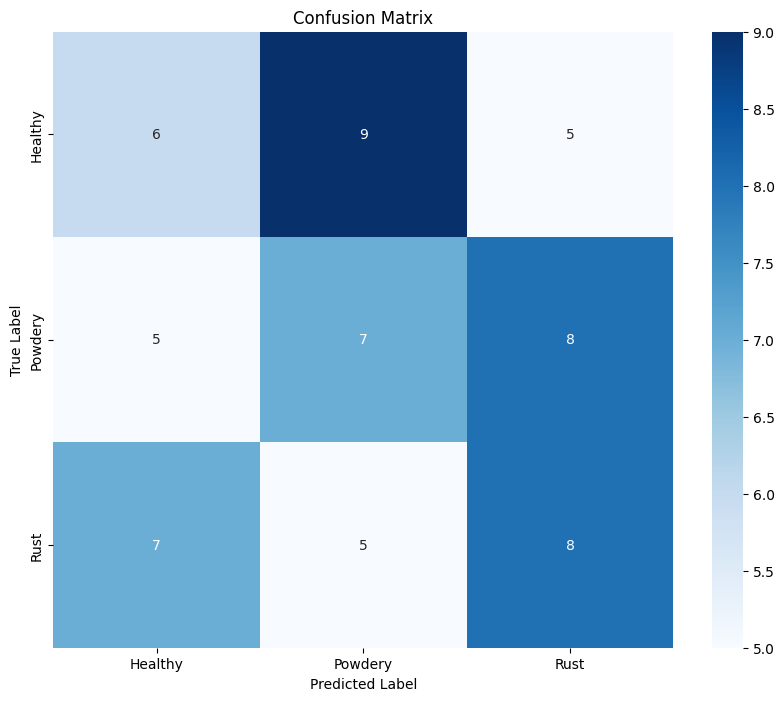

Classification Report
              precision    recall  f1-score   support

     Healthy       0.33      0.30      0.32        20
     Powdery       0.33      0.35      0.34        20
        Rust       0.38      0.40      0.39        20

    accuracy                           0.35        60
   macro avg       0.35      0.35      0.35        60
weighted avg       0.35      0.35      0.35        60



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels and predicted labels
validation_generator.reset()
predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report')
print(report)


In [ ]:
# Example usage
img_path = '/content/drive/MyDrive/Plant Disease Recognition/Train/Rust/8161733dfc3c1c65.jpg'  # Update with your test image path
img_array = preprocess_input_image(img_path)
predicted_class = predict_disease(model, img_array)
print(f'The predicted class is: {predicted_class}')


1/1 [==============================] - 4s 4s/step
The predicted class is: Rust
